In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/cityofla/CityofLA"))

def get_second_part(kw):
    sp = kw.split(':')
    if len(sp) > 1:
        return sp[1].replace(' ','')
    else:
        return 0

# Any results you write to the current directory are saved as output.

bulletins_prefix = '../input/cityofla/CityofLA/Job Bulletins/'

all_bulletins = os.listdir(bulletins_prefix)

df_array = []
# construct the data frame
next_keyword = ''
keywords = ['ANNUAL SALARY', 
            'NOTE', 
            'DUTIES',
            'PROCESS NOTES',
            'REQUIREMENT',
            'REQUIREMENTS1',
            'REQUIREMENT/MINIMUM QUALIFICATION',
            'PROCESS NOTES',
            'WHERE TO APPLY',
            'APPLICATION DEADLINE',
            'SELECTION PROCESS',
            'NOTICE']
for bulletin in all_bulletins:
    full_path = os.path.join(bulletins_prefix, bulletin)
    f = open(full_path, encoding = "ISO-8859-1")
    # FILE_NAME,
    new_item = { 'FILE_NAME': bulletin }
    for kw in keywords:
        new_item[kw] = ''
    for i, line in enumerate(f.readlines()):
        if i == 0:
            # JOB_CLASS_TITLE
            new_item['JOB_CLASS_TITLE'] = line
            continue
        if 'Class Code' in line:
            # JOB_CLASS_NO
            new_item['JOB_CLASS_NO'] = get_second_part(line)
            continue
        if 'Open Date' in line:
            new_item['OPEN_DATE'] = get_second_part(line)
            next_keyword = 'REQUIREMENTS' # the req line seems to come immediatly after to OPEN DATE Line
            continue
        # REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
        if next_keyword == 'REQUIREMENTS':
            new_item['REQUIREMENTS'] = line
            next_keyword = ''
            continue
        new_keyword = False
        for kw in keywords:
            if kw in line:
                next_keyword = kw
                new_keyword = True
                break
        if new_keyword:
            continue
        if next_keyword == '':
            continue
        new_item[next_keyword] += line
    df_array.append(new_item)
                
df = pd.DataFrame(df_array)
df.head()

['cityofla']
['Additional data', 'Job Bulletins']


,ANNUAL SALARY,APPLICATION DEADLINE,DUTIES,FILE_NAME,JOB_CLASS_NO,JOB_CLASS_TITLE,NOTE,NOTICE,OPEN_DATE,PROCESS NOTES,REQUIREMENT,REQUIREMENT/MINIMUM QUALIFICATION,REQUIREMENTS,REQUIREMENTS1,SELECTION PROCESS,WHERE TO APPLY
0,"\n$48,797 to $71,326\n\n",\n\n\nApplications must be received by THURSDA...,\nAn Arts Associate performs a broad range of ...,ARTS ASSOCIATE 2454 072117 REV 072817.txt,0,ARTS ASSOCIATE\n,\n1. Candidates from the eligible list are nor...,,07-21-17\n,,\n1. A bachelor's degree from an accredited fo...,,...,,"\nAfter meeting minimum qualifications, and in...",\nApplications will only be accepted on-line. ...
1,"\n$94,941 (Flat-Rated)\nThe salary for positio...",\nApplications and Qualifications Questionnair...,\nA Senior Communications Electrician acts as ...,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,0,SENIOR COMMUNICATIONS ELECTRICIAN\n,\n\n1. For information regarding reciprocity b...,,03-03-17\n,,\nTwo years of full-time paid experience in a ...,,(Exam Open to Current City Employees)\n,,"\nAfter meeting minimum qualifications, candid...",\nApplications will only be accepted on-line. ...
2,"\n$103,126 and $111,875 (flat-rated)\n\n","\nApplications must be received by THURSDAY, D...",\nA Senior Automotive Supervisor assists in pl...,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,0,SENIOR AUTOMOTIVE SUPERVISOR\n,\nThe current salary range is subject to chang...,,11-20-15\n,,\t\nTwo years of full-time paid experience wit...,,\t\t\t\t\t\t(Exam Open to Current City Employe...,,\nExamination Weights: Essay . . . . . . . ....,\nApplications will only be accepted on-line. ...
3,"\n$43,973 to $62,556, $50,634 to $72,077 and $...",\nFiling may be closed without prior notice af...,\nA Wastewater Collection Worker performs a va...,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,0,WASTEWATER COLLECTION WORKER\n,\n\n1. Candidates from the eligible list are n...,,10-26-12\n,,\n1. One year of full-time paid experience wit...,,Revised: 09-28-17\n,,"\nAfter meeting minimum qualifications, candid...",\nApplications will only be accepted on-line. ...
4,"\n$52,806 to $77,172 The salary range in the D...","\nApplications must be received by THURSDAY, J...","\nA Senior Storekeeper assigns, reviews and ev...",SENIOR STOREKEEPER 1837 052518.txt,0,SENIOR STOREKEEPER\n,\n\n1. Candidates from the eligible list are n...,,05-25-18\n,,\nTwo years of full-time paid experience as a ...,,...,,\nExamination Weights:\tWritten Test . . . . ....,\nApplications will only be accepted on-line. ...


In [24]:
# lets do some cleaning, to replace newlines and all that

def clean_line(row):
    for col in df.columns:
        row[col] = str(row[col]).replace('\n','').replace('\n52','')
    return row

df = df.apply(clean_line, axis=1)
df.head()

,ANNUAL SALARY,APPLICATION DEADLINE,DUTIES,FILE_NAME,JOB_CLASS_NO,JOB_CLASS_TITLE,NOTE,NOTICE,OPEN_DATE,PROCESS NOTES,REQUIREMENT,REQUIREMENT/MINIMUM QUALIFICATION,REQUIREMENTS,REQUIREMENTS1,SELECTION PROCESS,WHERE TO APPLY
0,"$48,797 to $71,326","Applications must be received by THURSDAY, AUG...",An Arts Associate performs a broad range of en...,ARTS ASSOCIATE 2454 072117 REV 072817.txt,0,ARTS ASSOCIATE,1. Candidates from the eligible list are norma...,,07-21-17,,1. A bachelor's degree from an accredited four...,,...,,"After meeting minimum qualifications, and in a...",Applications will only be accepted on-line. Wh...
1,"$94,941 (Flat-Rated)The salary for positions i...",Applications and Qualifications Questionnaires...,A Senior Communications Electrician acts as a ...,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,0,SENIOR COMMUNICATIONS ELECTRICIAN,1. For information regarding reciprocity betwe...,,03-03-17,,Two years of full-time paid experience in a cl...,,(Exam Open to Current City Employees),,"After meeting minimum qualifications, candidat...",Applications will only be accepted on-line. Wh...
2,"$103,126 and $111,875 (flat-rated)","Applications must be received by THURSDAY, DEC...",A Senior Automotive Supervisor assists in plan...,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,0,SENIOR AUTOMOTIVE SUPERVISOR,The current salary range is subject to change....,,11-20-15,,\tTwo years of full-time paid experience with ...,,\t\t\t\t\t\t(Exam Open to Current City Employees),,Examination Weights: Essay . . . . . . . . ....,Applications will only be accepted on-line. Wh...
3,"$43,973 to $62,556, $50,634 to $72,077 and $53...",Filing may be closed without prior notice afte...,A Wastewater Collection Worker performs a vari...,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,0,WASTEWATER COLLECTION WORKER,1. Candidates from the eligible list are norma...,,10-26-12,,1. One year of full-time paid experience with ...,,Revised: 09-28-17,,"After meeting minimum qualifications, candidat...",Applications will only be accepted on-line. Wh...
4,"$52,806 to $77,172 The salary range in the Dep...","Applications must be received by THURSDAY, JUN...","A Senior Storekeeper assigns, reviews and eval...",SENIOR STOREKEEPER 1837 052518.txt,0,SENIOR STOREKEEPER,1. Candidates from the eligible list are norma...,,05-25-18,,Two years of full-time paid experience as a St...,,...,,Examination Weights:\tWritten Test . . . . . ....,Applications will only be accepted on-line. Wh...


In [25]:
import textblob

blob_columns = ['DUTIES', 'NOTE', 'SELECTION PROCESS']

# whole_text = dict()
positive_jobs = dict()
negative_jobs = dict()

def get_blob_sentiment(row):
    row['polarity'] = 0
    row['subjectivity'] = 0
    for col in blob_columns:
        row[col] = row[col].replace('.','. ').replace('/',' / ') # in some occasions there is not space after .
        polarity_col = col + '_Polarity'
        subjectivity_col = col + '_Subjectivity'
        blob = textblob.TextBlob(row[col])
        # vader_sentiment = sid.polarity_scores(row[col])['compound']
        row[polarity_col] = blob.sentiment.polarity
        row[subjectivity_col] = blob.sentiment.subjectivity
        row['polarity'] = row['polarity'] + blob.sentiment.polarity
        # row['polarity'] = row['polarity'] + vader_sentiment 
        row['subjectivity'] = row['subjectivity'] + blob.sentiment.subjectivity
    if row['polarity'] > 0:
        if row['JOB_CLASS_TITLE'] in positive_jobs.keys():
            positive_jobs[row['JOB_CLASS_TITLE']].append(row['polarity'])
        else:
            positive_jobs[row['JOB_CLASS_TITLE']] = [ row['polarity'] ]
    else:
        if row['JOB_CLASS_TITLE'] in negative_jobs.keys():
            negative_jobs[row['JOB_CLASS_TITLE']].append(-row['polarity'])
        else:
            negative_jobs[row['JOB_CLASS_TITLE']] = [ -row['polarity'] ]
        # for tag in blob.tags:
        #     if tag[1] in ('JJ',
        #                   'JJR',
        #                   'JJS',
        #                   'RB',
        #                   'RBR',
        #                   'RBS',
        #                   'VB',
        #                   'VBD',
        #                   'VBG',
        #                   'VBN',
        #                   'VBP',
        #                   'VBZ'):
        #         if tag[0] in whole_text.keys():
        #             whole_text[tag[0]].append(blob.sentiment.polarity)
        #         else:
        #             whole_text[tag[0]] = [ blob.sentiment.polarity ]
    return row


df = df.apply(get_blob_sentiment, axis=1)

            
for key in positive_jobs.keys():
    positive_jobs[key] = np.mean(positive_jobs[key]) * 1000
    

for key in negative_jobs.keys():
    negative_jobs[key] = np.mean(negative_jobs[key]) * 1000

df.head()

,ANNUAL SALARY,APPLICATION DEADLINE,DUTIES,FILE_NAME,JOB_CLASS_NO,JOB_CLASS_TITLE,NOTE,NOTICE,OPEN_DATE,PROCESS NOTES,REQUIREMENT,REQUIREMENT/MINIMUM QUALIFICATION,REQUIREMENTS,REQUIREMENTS1,SELECTION PROCESS,WHERE TO APPLY,polarity,subjectivity,DUTIES_Polarity,DUTIES_Subjectivity,NOTE_Polarity,NOTE_Subjectivity,SELECTION PROCESS_Polarity,SELECTION PROCESS_Subjectivity
0,"$48,797 to $71,326","Applications must be received by THURSDAY, AUG...",An Arts Associate performs a broad range of en...,ARTS ASSOCIATE 2454 072117 REV 072817.txt,0,ARTS ASSOCIATE,1. Candidates from the eligible list are norm...,,07-21-17,,1. A bachelor's degree from an accredited four...,,...,,"After meeting minimum qualifications, and in a...",Applications will only be accepted on-line. Wh...,0.122566,0.942431,0.043750,0.190972,0.022222,0.395726,0.056593,0.355733
1,"$94,941 (Flat-Rated)The salary for positions i...",Applications and Qualifications Questionnaires...,A Senior Communications Electrician acts as a ...,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,0,SENIOR COMMUNICATIONS ELECTRICIAN,1. For information regarding reciprocity betw...,,03-03-17,,Two years of full-time paid experience in a cl...,,(Exam Open to Current City Employees),,"After meeting minimum qualifications, candidat...",Applications will only be accepted on-line. Wh...,0.041926,1.090221,-0.070000,0.260000,0.026838,0.406976,0.085088,0.423246
2,"$103,126 and $111,875 (flat-rated)","Applications must be received by THURSDAY, DEC...",A Senior Automotive Supervisor assists in plan...,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,0,SENIOR AUTOMOTIVE SUPERVISOR,The current salary range is subject to change....,,11-20-15,,\tTwo years of full-time paid experience with ...,,\t\t\t\t\t\t(Exam Open to Current City Employees),,Examination Weights: Essay . . . . . . ...,Applications will only be accepted on-line. Wh...,0.440353,1.288505,0.284091,0.476136,0.052315,0.394824,0.103947,0.417544
3,"$43,973 to $62,556, $50,634 to $72,077 and $53...",Filing may be closed without prior notice afte...,A Wastewater Collection Worker performs a vari...,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,0,WASTEWATER COLLECTION WORKER,1. Candidates from the eligible list are norm...,,10-26-12,,1. One year of full-time paid experience with ...,,Revised: 09-28-17,,"After meeting minimum qualifications, candidat...",Applications will only be accepted on-line. Wh...,0.380433,1.403055,0.127500,0.460000,0.045433,0.433888,0.207500,0.509167
4,"$52,806 to $77,172 The salary range in the Dep...","Applications must be received by THURSDAY, JUN...","A Senior Storekeeper assigns, reviews and eval...",SENIOR STOREKEEPER 1837 052518.txt,0,SENIOR STOREKEEPER,1. Candidates from the eligible list are norm...,,05-25-18,,Two years of full-time paid experience as a St...,,...,,Examination Weights:\tWritten Test . . . . ...,Applications will only be accepted on-line. Wh...,0.236881,1.281171,0.128214,0.402143,0.040586,0.460874,0.068080,0.418155


After we have put the text in a table lets make a simple textblob sentiment analysis of it. This is a easy to use simple word by word evaluation of the text.
Every word has an assigned polarity and subjectivity given here: https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml
After taking into account modifier words (e.g. not very ...) the mean across the text passage is returned. See more detail here:
https://planspace.org/20150607-textblob_sentiment/

In [26]:
# lets see the histograms for a starter
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
plt.axis("on")
from scipy import stats

sns.set(color_codes=True)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.distplot(df['polarity'], ax=ax[0])
sns.distplot(df['subjectivity'], ax=ax[1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The NOTE columns seems somewhat boring. Sentiment and polarity are centered around normal levels. However DUTIES and SELECTION PROCESS do have some far out values.

In [27]:
plt.figure()

g = sns.jointplot(df['polarity'], df['subjectivity'], kind="scatter", height=7, space=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


There are two samples with extreme values for polarity

In [28]:
def display_file(filename, from_tag=None):
    f = open(filename)
    if from_tag:
        write = False
    else:
        write = True
    print(filename)
    for line in f.readlines():
        if write == True:
            for col in df.columns:
                if col in line:
                    write = False
        if from_tag:
            if from_tag in line:
                write = True
        if write:
            print(line)

# for i, row in df[(df['subjectivity']>1.4) & (df['polarity']<-0.6)].iterrows():
#    fname = os.path.join(bulletins_prefix, row['FILE_NAME'])
#     display_file(fname, from_tag='DUTIES')
print('Most negative')
print('---------------------------------------------------------------')
print(df[df['polarity'] == df['polarity'].min()]['DUTIES'].iloc[0])
print('---------------------------------------------------------------')
print('Most positive')
print('---------------------------------------------------------------')
print(df[df['polarity'] == df['polarity'].max()]['DUTIES'].iloc[0])

Most negative
---------------------------------------------------------------
An Animal Control Officer enforces State and City ordinances dealing with the care, treatment, licensing, and impounding of animals in an assigned area of the City; picks up sick, injured, stray, vicious or unwanted animals; conducts humane investigations; conducts permit inspections, issues citations, and makes arrests; may be required to handle money accurately and collect animal licensing and other fees; and keeps records and prepares reports which may be used as legal evidence.  Animal Control Officers may work alone at night and on graveyard shifts. 
---------------------------------------------------------------
Most positive
---------------------------------------------------------------
An Office Trainee assists in performing a variety of routine office tasks while becoming acquainted with clerical career opportunities in the City of Los Angeles. 	


The extremes make somehow sense. The Animal control officer gets the perspective of handling vicious animals on a graveyard alone and at night. It takes some very special character traits to thrive in this kind of environments.
On the other hand the Office Trainee becomes acquainted with career opportunities.

In [29]:
from wordcloud import WordCloud

wc = WordCloud(relative_scaling=1, background_color='white',
        max_words=250,
        max_font_size=40, 
        scale=3)

wordcloud = wc.generate_from_frequencies(positive_jobs)
# fig = plt.figure(1, figsize=(12, 12))
plt.figure()
plt.axis('off')
fig.suptitle('Most negative Jobs', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()
wordcloud = wc.generate_from_frequencies(negative_jobs)
# fig = plt.figure(1, figsize=(12, 12))
plt.figure()
plt.axis('off')
fig.suptitle('Most negative Jobs', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These words are in general associated with higher positivity of the resulting job bulletin. Some words seem somewhat airport service related to me. As the airport jobs seemed to be assiciated with higer salary we will have a look on incomes and job sectors in relation with bulletin tone.

In [30]:
# the annual salaray column is a bit messy, so some more cleaning is required here. 
# We will use everything that can be parsed to a number and take the median

def take_messy_median(row):
    spl = row['ANNUAL SALARY'].replace('.',' ').replace(';',' ').replace('(',' ').split(' ')
    nums = []
    for sp in spl:
        number = sp.replace('$','').replace(',','')
        try:
            number = float(number)
            nums.append(number)
        except:
            pass # we dont care right now about the exceptions
    if len(nums) == 0:
        print(row['ANNUAL SALARY']) # this line should be never printed. If it happens it must be fixed
        row['ANNUAL SALARY'] = None
    row['ANNUAL SALARY'] = np.median(nums)
    return row

df = df.apply(take_messy_median, axis=1)

# df['ANNUAL SALARY']
























Salary scale pending. Salary to be determined prior to appointment. 



/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Some jobs bulletins do not have a salary statement. We replace it with the mean 

In [32]:
mean_salary = df[df['ANNUAL SALARY'].notnull()]['ANNUAL SALARY'].mean()

print('Mean Salary: ' + str(mean_salary))

df = df[df['ANNUAL SALARY'].notnull()]

Mean Salary: 96553.31762917934


<IPython.core.display.Javascript object>


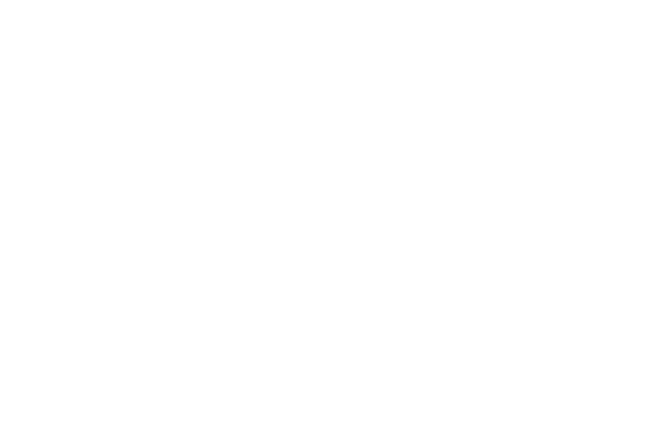

<IPython.core.display.Javascript object>


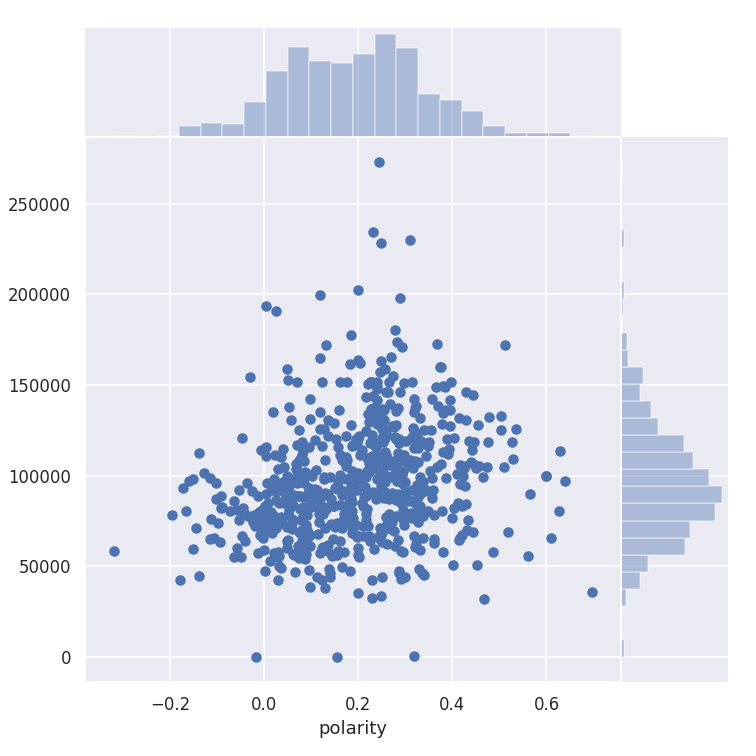

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [33]:
# df['ANNUAL SALARY']

plt.figure()

g = sns.jointplot(df['polarity'], df['ANNUAL SALARY'], kind="scatter", height=7, space=0)

In [34]:
duties = df[df['ANNUAL SALARY']>250000]['DUTIES'].iloc[0]
print(duties)
polarity = df[df['ANNUAL SALARY']>250000]['polarity'].iloc[0]
print('Polarity: ' + str(polarity))

A Chief Port Pilot supervises the work of a group of Port Pilots, Boat Captains,  Deck Hands, and dispatchers engaged in providing inbound and outbound vessels with piloting services in the Port of Los Angeles; pilots ocean-going ships arriving and departing the Port of Los Angeles; may serve on various maritime related committees or boards to enhance safety in the Port and satisfy existing and future customer needs; applies sound supervisory principles and techniques in building and maintaining an effective workforce; and fulfills equal employment opportunity responsibilities.  
Polarity: 0.2437152777777778
